# Processing and narrating a video with GPT's visual capabilities and the TTS API

This notebook demonstrates how to use GPT's visual capabilities with a video. GPT-4 doesn't take videos as input directly, but we can use vision and the new 128K context window to describe the static frames of a whole video at once. We'll walk through two examples:

1. Using GPT-4 to get a description of a video
2. Generating a voiceover for a video with GPT-4 and the TTS API


In [15]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import OpenAI
import os
import requests

client = OpenAI()


## 1. Using GPT's visual capabilities to get a description of a video


First we use OpenCV to extract frames from a nature [video](https://www.youtube.com/watch?v=kQ_7GtE529M) containing bisons and wolves:


In [16]:
video = cv2.VideoCapture("data/bison.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")


618 frames read.


Display frames to make sure we've read them in correctly:


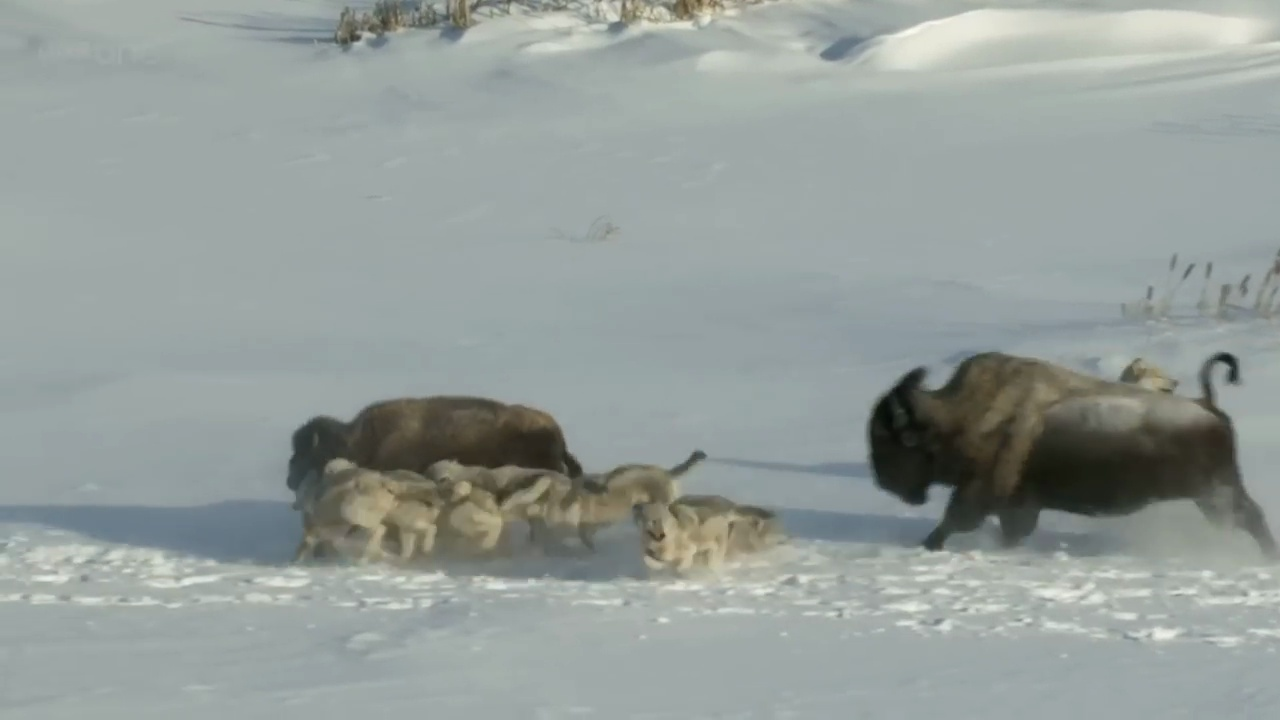

KeyboardInterrupt: 

In [17]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)


Once we have the video frames we craft our prompt and send a request to GPT (Note that we don't need to send every frame for GPT to understand what's going on):


In [25]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)


Title: "Survival at its Rawest: A Battle of Predators and Prey in the Winter Wilderness"

Description:
Witness the intense dynamics of nature's food chain in this gripping footage, where a pack of determined wolves challenges the formidable strength of a bison in a snow-covered landscape. Amidst the harsh winter conditions, each species fights for survival, showcasing their natural instincts and tactical prowess. The video captures a suspense-filled standoff and chase that unfolds across the pristine, white expanse, offering an unfiltered look at the struggles faced by wildlife in their quest for survival. Whether you're an animal enthusiast or a nature lover, this visual encounter is a poignant reminder of the incredible resilience of life in the wild. Tune in to experience the raw power and unpredictability of nature, where every moment can spell the difference between life and death. Please respect the natural environment and its inhabitants, as they play out the age-old dance of pr

## 2. Generating a voiceover for a video with GPT-4 and the TTS API


Let's create a voiceover for this video in the style of David Attenborough. Using the same video frames we prompt GPT to give us a short script:


In [27]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Create a short voiceover script in the style of David Attenborough. Only include the narration.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::60]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)


In the vast expanse of the winter wilderness, a drama unfolds under the watchful eye of the sun. Here we see a band of wolves, their coats thickened against the chill, engaging in one of nature's most raw and unforgiving spectacles.

The bison, a leviathan of the plains, finds itself mired in snow, its every breath sending up clouds into the crisp air. This ancient beast, usually unshakeable in its stride, is now facing the combined cunning of the wolf pack. The pack encircles their quarry, their strategy clear yet fraught with peril. They must work together, cogs in a machine driven by survival, each move as deliberate as it is dangerous.

Notice how the wolves probe and feint, testing the bison's defenses. Their dance is one of life and death, a choreography honed by generations of such encounters. The pack's younger members learn from the experienced, understanding that while the risk is great, the reward is sustenance.

The bison, despite its formidable size and strength, tires aga

Now we can pass the script to the TTS API where it will generate a mp3 of the voiceover:


In [31]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    },
    json={
        "model": "tts-1",
        "input": result.choices[0].message.content,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)
